In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from pathlib import Path
from astropy.table import Table, vstack
from regions import CircleSkyRegion

from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.maps import Map
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel,
    Models,
)
from gammapy.estimators import ExcessMapEstimator
from gammapy.estimators.utils import find_peaks

import library_functions

## Data reduction

In [2]:
config = AnalysisConfig()
#print(config)

# Selecting the observations
config.observations.datastore = "/home/lucagiunti/gammapy-datasets/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]
config.datasets.type = "3d"  # Analysis type is 3D

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.width = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.methods = ["aeff-max", "offset-max", "bkg-peak"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true energy binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "12 TeV"
config.datasets.geom.axes.energy_true.nbins = 14

In [3]:
analysis = Analysis(config)
analysis.get_observations()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
No HDU found matching: OBS_ID = 110380, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 111140, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 111159, HDU_TYPE = rad_max, HDU_CLASS = None
Number of selected observations: 3


In [4]:
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

In [5]:
stacked = library_functions.run_data_reduction(analysis, None, model_simu)

Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
stacked.excess.smooth(0.05 * u.deg).plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

# First look at significance

In [7]:
dataset = stacked
correlation_radius = 0.1 * u.deg
energy_edges = [0.5, 10] * u.TeV
estimator_excess = ExcessMapEstimator(
    correlation_radius=correlation_radius,
    n_sigma=1, 
    n_sigma_ul=3,
    selection_optional=None,
    energy_edges=energy_edges, 
)
result = estimator_excess.run(dataset)

/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


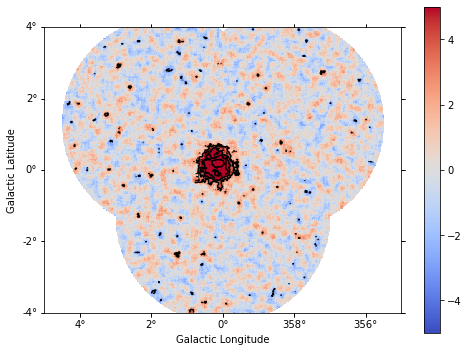

In [8]:
library_functions._plot_significance_map(result)

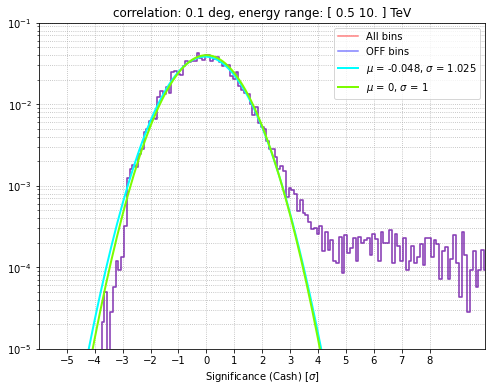

In [9]:
library_functions._pretty_plot_1d_significance(
    result,
    correlation_radius,
    energy_edges, 
    exclusion=Map.from_geom(result["sqrt_ts"].geom, data=np.ones_like(result["sqrt_ts"].data))
)

# Exclusion mask computation

In [10]:
sigma = 4
radius = correlation_radius

In [11]:
dataset_1 = dataset
result_1 = result
regions_1 = []
skydirs_1 = []
stable = False

idx = 1
while stable == False:
    len_regions_before = len(regions_1)
    sources = find_peaks(
        result_1["sqrt_ts"],
        threshold=sigma,
        min_distance=1,
    )

    for source in sources:
        skydir = SkyCoord(source["ra"], source["dec"], unit="deg", frame="icrs")
        if skydir not in skydirs_1:
            skydirs_1.append(skydir)
            circle = CircleSkyRegion(skydir, radius)
            regions_1.append(circle)
    print(f"Iteration: {idx}. Seeds: {len(regions_1)}")
    len_regions_after = len(regions_1)
    if len_regions_before == len_regions_after:
        stable = True
        continue
    idx += 1
    
    exclusion_minimal_1 = dataset.counts.geom.to_image().region_mask(regions=regions_1, inside=False)
    exclusion_minimal_1.write("./exclusion_minimal_1.fits", overwrite=True)
    dataset_1 = library_functions.run_data_reduction(analysis, "./exclusion_minimal_1.fits", model_simu)

    estimator_excess = ExcessMapEstimator(
        correlation_radius=correlation_radius,
        n_sigma=1, 
        n_sigma_ul=3,
        selection_optional=None,
        energy_edges=energy_edges, 
    )
    result_1 = estimator_excess.run(dataset_1)

Iteration: 1. Seeds: 101


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 2. Seeds: 225


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 3. Seeds: 308


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 4. Seeds: 358


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 5. Seeds: 400


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 6. Seeds: 439


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 7. Seeds: 502


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 8. Seeds: 509


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 9. Seeds: 509


/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


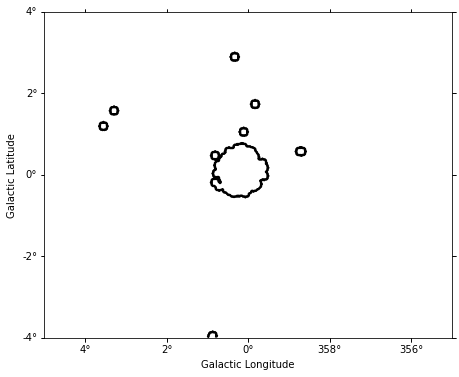

In [12]:
library_functions._compare_exclusions([exclusion_minimal_1])

/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


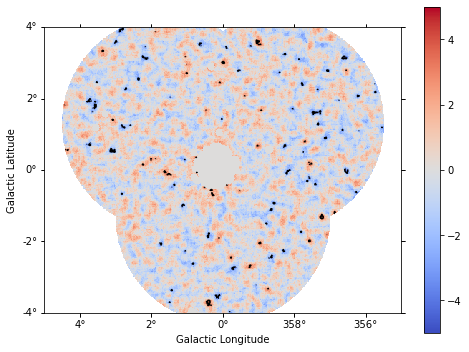

In [13]:
library_functions._plot_significance_map(result_1, exclusion=exclusion_minimal_1)

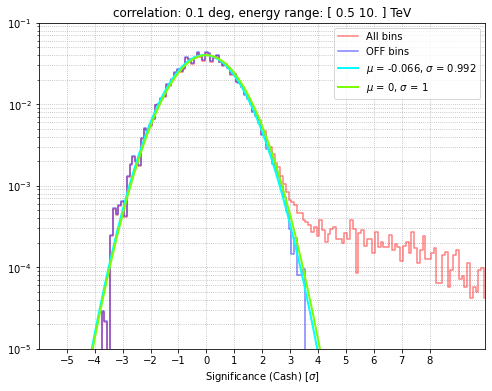

In [14]:
library_functions._pretty_plot_1d_significance(
    result_1,
    correlation_radius,
    energy_edges, 
    exclusion=exclusion_minimal_1
)

mask also negative fluctuations

In [15]:
dataset_2 = dataset
result_2 = result
regions_2 = []
skydirs_2 = []
stable = False

idx = 1
while stable == False:
    len_regions_before = len(regions_2)
    sources = find_peaks(
        result_2["sqrt_ts"],
        threshold=sigma,
        min_distance=1,
    )
    res_negative = Map.from_geom(result_2["sqrt_ts"].geom, data=-result_2["sqrt_ts"].data)
    sources_negative = find_peaks(
        res_negative,
        threshold=sigma,
        min_distance=1,
    )
    sources = vstack([sources, sources_negative])
    
    for source in sources:
        skydir = SkyCoord(source["ra"], source["dec"], unit="deg", frame="icrs")
        if skydir not in skydirs_2:
            skydirs_2.append(skydir)
            circle = CircleSkyRegion(skydir, radius)
            regions_2.append(circle)
    print(f"Iteration: {idx}. Seeds: {len(regions_2)}")
    len_regions_after = len(regions_2)
    if len_regions_before == len_regions_after:
        stable = True
        continue
    idx += 1
    
    exclusion_minimal_2 = dataset.counts.geom.to_image().region_mask(regions=regions_2, inside=False)
    exclusion_minimal_2.write("./exclusion_minimal_2.fits", overwrite=True)
    dataset_2 = library_functions.run_data_reduction(analysis, "./exclusion_minimal_2.fits", model_simu)

    estimator_excess = ExcessMapEstimator(
        correlation_radius=correlation_radius,
        n_sigma=1, 
        n_sigma_ul=3,
        selection_optional=None,
        energy_edges=energy_edges, 
    )
    result_2 = estimator_excess.run(dataset_2)

Iteration: 1. Seeds: 101


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 2. Seeds: 228


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 3. Seeds: 317


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 4. Seeds: 387


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 5. Seeds: 471


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 6. Seeds: 536


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 7. Seeds: 541


Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Iteration: 8. Seeds: 541


/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


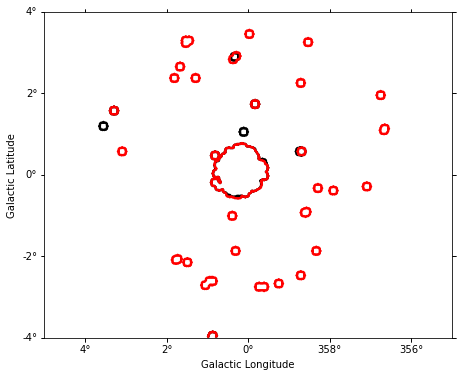

In [16]:
library_functions._compare_exclusions([exclusion_minimal_1, exclusion_minimal_2])

/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


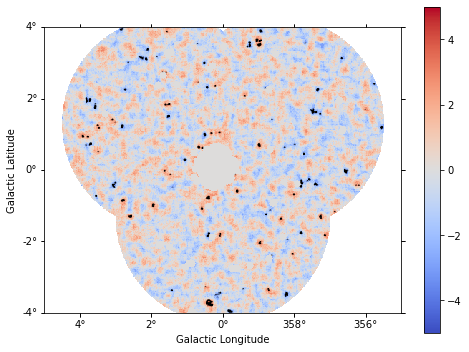

In [17]:
library_functions._plot_significance_map(result_2, exclusion=exclusion_minimal_2)

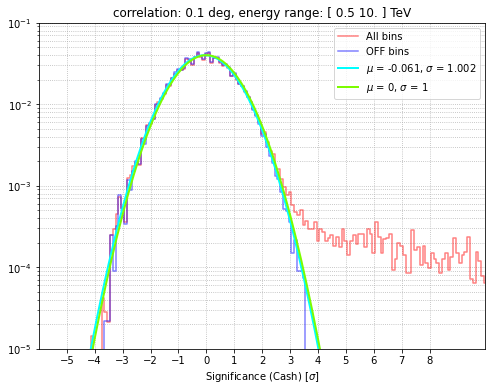

In [18]:
library_functions._pretty_plot_1d_significance(
    result_2,
    correlation_radius,
    energy_edges, 
    exclusion=exclusion_minimal_2
)

/home/lucagiunti/miniconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


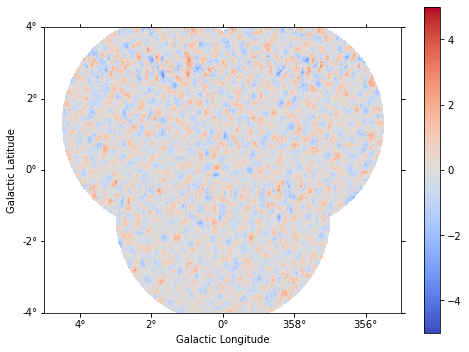

In [19]:
library_functions._compare_significance_maps(result_1, result_2)